In [1]:
from sympy import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import optimize

In [5]:
# Test parameter
ConstitutiveModels = ['NeoHookean']
ConstitutiveModel  = ConstitutiveModels[0]

StretchRange = [0.1, 5.0]                    # Stretch ratio interval
StretchDelta =  0.01                         # Step size

# Material Parameters
LambdaValue =  1E6   # 1st Lamé parameter
MuValue     =  660   # 2nd Lamé parameter (Shear modulus) (Pa)

C01Value    =  0.00   # Mooney-Rivlin 3rd material constant (kPa) if == 0 => Neo-Hookean
JmValue     =  0.08   # Gent 3rd material constant (-) if == 1 => ~Neo-Hookean with ln
BetaValue   =  20.3   # Demiray 3rd material constant (-) if == 1 => ~Neo-Hookean with exp
AlphaValue  = -24.3   # Ogden 3rd material constant (-) if == 2 => Neo-Hookean

# Folder for the results
Output_Path = os.path.join('Results','Compressible',ConstitutiveModel)
os.makedirs(Output_Path, exist_ok=True)
StretchArray = np.arange(StretchRange[0],StretchRange[1],StretchDelta)
AnalyticalStress = pd.DataFrame({'Stretch ratio (-)':StretchArray})

<lambdifygenerated-7>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (((1/3)*Dummy_184*(-Dummy_185**2 + J/Dummy_185) + Dummy_186*J**(5/3)*(J - 1))/J**(5/3))
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (((1/3)*Dummy_187/Dummy_188 + Dummy_189*J**(5/3) + (5/3)*Dummy_189*J**(2/3)*(J - 1))/J**(5/3) - 5/3*((1/3)*Dummy_187*(-Dummy_188**2 + J/Dummy_188) + Dummy_189*J**(5/3)*(J - 1))/J**(8/3))


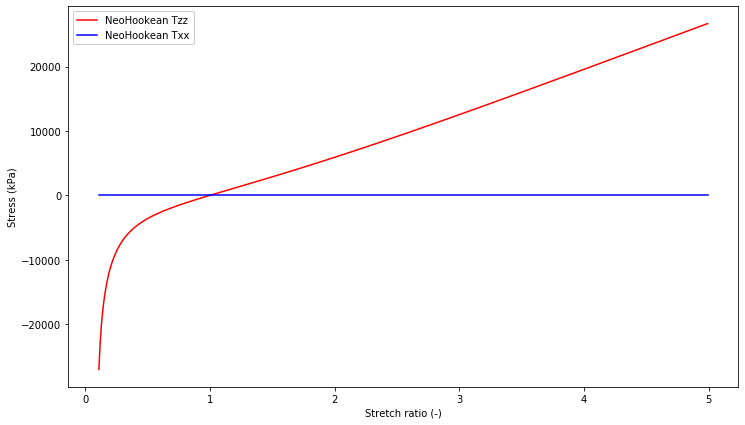

In [6]:
# Symbolic material parameters
Lambda, Mu   = symbols(r'\lambda \mu', positive=True)

# Identity tensor
I = eye(3)

# Direction vectors
e1 = I[:,0]
e2 = I[:,1]
e3 = I[:,2]

# Dilatation coefficients
LambdaH = 1                                      # Coefficient for homogeneous dilatation
LambdaX = symbols(r'\lambda_x', positive=True)   # Coefficient for lengthening in e1 direction (here <1)
LambdaY = symbols(r'\lambda_y', positive=True)   # Coefficient for lengthening in e2 direction (here <1)
LambdaZ = symbols(r'\lambda_z', positive=True)   # Coefficient for lengthening in e3 direction (here >1)

# Deformation matrices
U = I + (LambdaX-1) * np.outer(e1,e1) + (LambdaY-1) * np.outer(e2,e2) + (LambdaZ-1) * np.outer(e3,e3)

# Gradient of the deformation
F = (LambdaH-1) * I + U

# Volume change
J = det(F)

# Right Cauchy-Green strain tensor
C = transpose(F) * F

# Eigenvalues of Right Cauchy-Green strain tensor
Lambda1, Lambda2, Lambda3 = symbols(r'\lambda_1 \lambda_2 \lambda_3')

# Invariants
J, I1, I2, I1b, I2b = symbols(r'J I_1 I_2 \bar{I_1} \bar{I_2}')
JFunction   = Lambda1*Lambda2*Lambda3
I1Function  = Lambda1**2+Lambda2**2+Lambda3**2
I2Function  = Lambda1**2*Lambda2**2 + Lambda2**2*Lambda3**2 + Lambda3**2*Lambda1**2
I1bFunction = J**Rational(-2,3)*I1
I2bFunction = J**Rational(-4,3)*I2

# Hyperelastic models (Compressible)
if ConstitutiveModel == ConstitutiveModels[0]:     # Neo-Hookean
    C1, D1       = symbols(r'C_1 D_1', positive=True)
    C1Function   = Mu / 2
    D1Function   = Lambda / 2
    Psi          = C1 * (I1b - 3) + D1 * (J-1)**2

Psi = Psi.subs({C1:C1Function, D1:D1Function})
PsiLambda = Psi.subs({I1b:I1bFunction,I2b:I2bFunction})
PsiLambda = PsiLambda.subs({J:JFunction,I1:I1Function,I2:I2Function})

T1 = Lambda1*Derivative(PsiLambda, Lambda1) / (Lambda1*Lambda2*Lambda3)
T1 = T1.doit()

T2 = Lambda2*Derivative(PsiLambda, Lambda2) / (Lambda1*Lambda2*Lambda3)
T2 = T2.doit()

T3 = Lambda3*Derivative(PsiLambda, Lambda3) / (Lambda1*Lambda2*Lambda3)
T3 = T3.doit()

# Uniaxial stretch
LambdaY = LambdaX

JFunction_Uniaxial = JFunction.subs({Lambda1:LambdaX, Lambda2:LambdaY, Lambda3:LambdaZ})
LambdaXFunction_Uniaxial = solve(JFunction_Uniaxial-J, LambdaX)[1]

T = T1 * np.outer(e1,e1) + T2 *np.outer(e2,e2) + T3 * np.outer(e3,e3)
T = Matrix(T).doit()
T = simplify(T)
T = T.subs({Lambda1:LambdaXFunction_Uniaxial,Lambda2:LambdaXFunction_Uniaxial,Lambda3:LambdaZ})
TxxFunction = lambdify((LambdaZ, J, Lambda, Mu), T[0,0], 'numpy')
TzzFunction = lambdify((LambdaZ, J, Lambda, Mu), T[2,2], 'numpy')

# Estimate the value of J
JEquation = T[0,0]
JEquationPrime = diff(T[0,0], J)
JEstimation = lambdify((J, LambdaZ, Lambda, Mu), JEquation, 'numpy')
JEstimationPrime = lambdify((J, LambdaZ, Lambda, Mu), JEquationPrime, 'numpy')

def JComputation(Stretch, LambdaValue, MuValue):
    JComputed = optimize.root_scalar(JEstimation, x0=1, args=(Stretch, LambdaValue, MuValue), method='newton', fprime=JEstimationPrime)
    return JComputed

def StressComputation(StretchArray, LambdaValue, MuValue):
    
    Txx = np.zeros(StretchArray.shape)
    Tzz = np.zeros(StretchArray.shape)
    
    for i in range(StretchArray.shape[0]):
        Stretch = StretchArray[i]
        try:
            JComputed  = JComputation(Stretch, LambdaValue, MuValue)
            JEstimated = JComputed.root
            Txx[i] = TxxFunction(Stretch, JEstimated, LambdaValue, MuValue)
            Tzz[i] = TzzFunction(Stretch, JEstimated, LambdaValue, MuValue)
        except Exception as e:
            print(e)
            Txx[i] = np.nan
            Tzz[i] = np.nan
    return Tzz, Txx

Tzz, Txx = StressComputation(StretchArray, LambdaValue, MuValue)

if ConstitutiveModel == ConstitutiveModels[0]:                            # Neo-Hookean
    AnalyticalStress[ConstitutiveModel + ' Tzz (Pa)'] = Tzz
    AnalyticalStress[ConstitutiveModel + ' Txx (Pa)'] = Txx
    
AnalyticalStress.to_csv(os.path.join(Output_Path,'Lambda' + str(LambdaValue/1E6) + 'E6_Mu' + str(MuValue) + '.csv'), index=False)